# Cryptobot trading algorithm

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

In [25]:
%matplotlib inline

### Read n hours of dump and format for further processing

In [26]:
HOURS = 6

df = pd.read_csv('/vagrant/dump.csv')
df = df.drop('price_id', 1)
df = df.drop('exchange_code', 1)
df = df.drop('primary_currency', 1)
df = df.drop('secondary_currency', 1)
df = df[-60*HOURS:]
df = df.reset_index(drop=True)
print(len(df))

360


### Calculation of the rolling averages

In [27]:
def calculate_averages(df, short_count, long_count):
    short_avg = {}
    long_avg = {}
    
    for idx, price in enumerate(df.loc[:,'price']):
        if idx > short_count:
            total = 0
            for x in range(0, short_count):
                total = total + df['price'][idx-x]
            short_avg[df['time'][idx]] = total/short_count
    
        if idx > long_count:
            total = 0
            for x in range(0, long_count):
                total = total + df['price'][idx-x]
            long_avg[df['time'][idx]] = total/long_count

    df['short_avg'] = df['time'].map(short_avg)
    df['long_avg'] = df['time'].map(long_avg)
    
    return df

### Calculate the buy and sell decisions.

In [28]:
#TODO: im trade.py immer einfach 90% nehmen und dann 1/anzahl (und nicht 1/anzahl+1)

def calculate_decisions(df, short_count, long_count):
    actions_sell = {}
    actions_buy = {}

    for idx, price in enumerate(df.loc[:,'price']):
        if idx > long_count:
            now = idx
            before = idx-1
    
            try:
                short_avg_moves_above_long_avg = df['short_avg'][before] < df['long_avg'][before] and \
                                                df['short_avg'][now] >= df['long_avg'][now]
                short_avg_moves_below_long_avg = df['short_avg'][before] > df['long_avg'][before] and \
                                                 df['short_avg'][now] <= df['long_avg'][now]

                if short_avg_moves_above_long_avg:
                    actions_buy[df['time'][idx]] = price

                elif short_avg_moves_below_long_avg:
                    actions_sell[df['time'][idx]] = price
            except:
                pass
            
    df['sell'] = df['time'].map(actions_sell)
    df['buy'] = df['time'].map(actions_buy)            
    
    return df

### Calculate the gains / losses

In [29]:
def calculate_performance(df, start_budget):
    budget_usd = start_budget
    budget_btc = 0

    for idx, price in enumerate(df.loc[:,'price']):
        if not np.isnan(df['buy'][idx]):
            new_btc = budget_usd/df['buy'][idx]
            budget_btc += new_btc
            budget_usd = 0
        
        if not np.isnan(df['sell'][idx]):
            new_usd = budget_btc*df['sell'][idx]
            budget_usd += new_usd
            budget_btc = 0
        
    end_budget = (budget_usd+budget_btc*df['price'].iloc[-1])

    result = (end_budget-start_budget)/start_budget*100
    return result

## Run Algorithm with one configuration

These are the main configuration items for the algorithm. The algorithm is base on two rolling averages. If the two averages cross, a buy or sell is initiated. Here you can choose the number of elements the averages should be calculated with:

In [30]:
SHORT_AVG_COUNT = 65
LONG_AVG_COUNT = 75

In [31]:
df = calculate_averages(df, SHORT_AVG_COUNT, LONG_AVG_COUNT)

In [32]:
df = calculate_decisions(df, SHORT_AVG_COUNT, LONG_AVG_COUNT)

In [33]:
start_budget = 1000
result = calculate_performance(df, start_budget)
print('Result: {:.2f} %'.format(result))

budget_btc = start_budget/df['price'][0]
end_budget = (budget_btc*df['price'].iloc[-1])
result = (end_budget-start_budget)/start_budget*100
print('Result without code: {:.2f} %'.format(result))

Result: 2.83 %
Result without code: 2.01 %


## Find optimal configuration (extended)

In [ ]:
intervals = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]
day_intervals = [1*24*60, 3*24*60, 5*24*60, 7*24*60, 14*24*60]

results = {}

def chunks(items, n):
    for i in range(0, len(items), n):
        yield items[i:i+n]

for day_interval in day_intervals:
    for chunk_idx, chunk in enumerate(chunks(df, day_interval)):
        for interval in intervals: 
            for interval2 in intervals:
                if interval2 > interval:
                    chunk = chunk.reset_index(drop=True)
                    df1 = chunk.copy()
                    df1 = calculate_averages(df1, interval, interval2)
                    df1 = calculate_decisions(df1, interval, interval2)
                    start_budget = 1000
                    result = calculate_performance(df1, start_budget)
                    key = '{}d-#{}-{}m-{}m'.format(int(day_interval/24/60), chunk_idx, interval, interval2)
                    results[key] = result
                    print('Result {}: {:.2f} %'.format(key, result))


In [12]:
# write results to file
with open('results.csv', 'w') as outfile:
    for key in results.keys():
        outfile.write('{};{}\n'.format(key, results[key]))

# hier die top 3 intervalle für die 1d-14d listen.

## Find optimal configuration (simple)

In [15]:
intervals = [60, 65, 70, 75, 80, 85, 90, 100, 110, 120]

for interval in intervals:
    for interval2 in intervals:
        if interval2 > interval:
            df = calculate_averages(df, interval, interval2)
            df = calculate_decisions(df, interval, interval2)
            start_budget = 1000
            result = calculate_performance(df, start_budget)
            print('Result({}/{}): {:.2f} %'.format(interval, interval2, result))

Result(60/65): 1.28 %
Result(60/70): 2.33 %
Result(60/75): 2.03 %
Result(60/80): 0.19 %
Result(60/85): 2.04 %
Result(60/90): 1.83 %
Result(60/100): 0.65 %
Result(60/110): 0.73 %
Result(60/120): 1.14 %
Result(65/70): 1.49 %
Result(65/75): 2.83 %
Result(65/80): 1.85 %
Result(65/85): 0.90 %
Result(65/90): 0.61 %
Result(65/100): 1.01 %
Result(65/110): 1.14 %
Result(65/120): 0.41 %
Result(70/75): 2.12 %
Result(70/80): 1.48 %
Result(70/85): 0.54 %
Result(70/90): 1.04 %
Result(70/100): 0.89 %
Result(70/110): 0.41 %
Result(70/120): 1.03 %
Result(75/80): 0.58 %
Result(75/85): 1.58 %
Result(75/90): 1.34 %
Result(75/100): 1.03 %
Result(75/110): 1.03 %
Result(75/120): 1.03 %
Result(80/85): 1.24 %
Result(80/90): 0.51 %
Result(80/100): 1.03 %
Result(80/110): 1.03 %
Result(80/120): 0.49 %
Result(85/90): -0.01 %
Result(85/100): 1.03 %
Result(85/110): 1.10 %
Result(85/120): 1.01 %
Result(90/100): 0.49 %
Result(90/110): 1.01 %
Result(90/120): 0.90 %
Result(100/110): 0.89 %
Result(100/120): 0.97 %
Result

#### Visualize the algorithm

In [34]:
# DO NOT RUN THIS PART if you want to run the "find the optimal configuration" script
# Convert index to datetime (for nicer charts)

df['time'] = df['time'].apply(pd.to_datetime)
df = df.set_index('time')

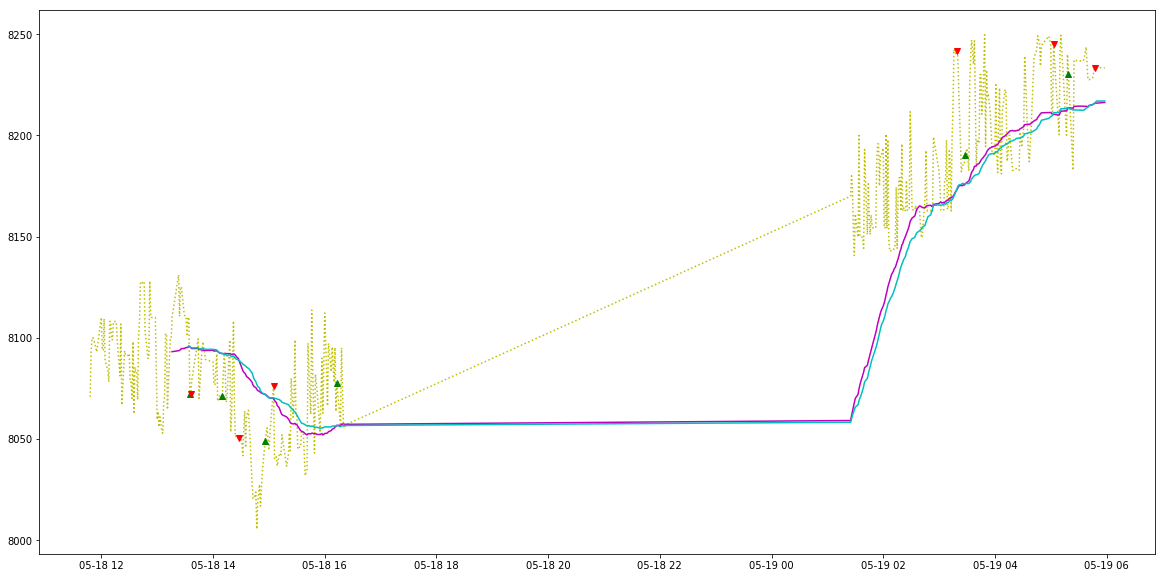

In [35]:
# Plot the prices, the averages and the buys and sells.
mpl.rcParams['figure.figsize'] = (20, 10)  # make graph bigger

ts_price = df.loc[:,'price']
ts_sell = df.loc[:,'sell']
ts_buy = df.loc[:,'buy']
ts_short_avg = df.loc[:, 'short_avg']
ts_long_avg = df.loc[:, 'long_avg']

fig, ax1 = plt.subplots()
ax1.plot(ts_price.index, ts_price, 'y:')       
ax1.plot(ts_buy.index, ts_buy,'g^') # GREEN UP ARROW -> BUY
ax1.plot(ts_sell.index, ts_sell,'rv')  # RED DOWN ARROW -> SELL
ax1.plot(ts_short_avg.index, ts_short_avg,'m-') 
ax1.plot(ts_long_avg.index, ts_long_avg,'c-') 
